In [ ]:
!pip install pettingzoo==1.24.0
!pip install supersuit
!pip install gymnasium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.6/563.6 kB 7.6 MB/s eta 0:00:00


In [ ]:
!pip install stable-baselines3==2.2.1  #gives PPO implementation
!pip install gymnasium==0.29.1
!pip install pettingzoo
!pip install pygame


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.2
    Uninstalling gymnasium-1.2.2:
      Successfully uninstalled gymnasium-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
supersuit 3.10.0 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


In [ ]:
from pettingzoo.mpe import simple_spread_v3

# Create the environment
env = simple_spread_v3.parallel_env()
env.reset()

print("Environment loaded successfully!")
print("Agents:", env.agents)


Environment loaded successfully!
Agents: ['agent_0', 'agent_1', 'agent_2']


PettingZoo installed correctly, my baseline environment simple_spread loads. I have three agents
1. independent agents
2. distributed agents (team communication)

In [ ]:
# Let's inspect the observation and action spaces of each agent.
# to understand what information each agent receives (their "view" of the environment)
# - what actions they can take (movement, staying still, etc.)
# - essential for building a distributed/communication framework later


import gymnasium as gym

print("Observation space:", env.observation_space(env.agents[0]))
print("Action space:", env.action_space(env.agents[0]))

Observation space: Box(-inf, inf, (18,), float32)
Action space: Discrete(5)


This means each agent receives:

A vector of 18 numbers

These numbers include:

agent’s own position

agent’s velocity

positions of landmarks

relative positions of other agents. Discrete(5) means 0-> stay still, 1-> move left, 2-> move right, 3-> move up, 4-> move down.

Episode 1 reward: -56.97435593883838
Episode 2 reward: -57.596599346399
Episode 3 reward: -96.4984782300433
Episode 4 reward: -114.50504880070673
Episode 5 reward: -66.47557297178706
Episode 6 reward: -69.60619343692132
Episode 7 reward: -88.40050225790148
Episode 8 reward: -100.51058608049362
Episode 9 reward: -160.69526158363652
Episode 10 reward: -106.3159493498571
Episode 11 reward: -131.52691690021516
Episode 12 reward: -78.78096177274553
Episode 13 reward: -40.09324402875077
Episode 14 reward: -65.4578626270818
Episode 15 reward: -112.42044553822528
Episode 16 reward: -81.91459871531528
Episode 17 reward: -81.38630832022736
Episode 18 reward: -72.74013198765674
Episode 19 reward: -64.5001211597148
Episode 20 reward: -94.53610760192387
Episode 21 reward: -78.58976211312199
Episode 22 reward: -79.65684515194152
Episode 23 reward: -93.08718164304491
Episode 24 reward: -69.24808391873373
Episode 25 reward: -64.78614406891546
Episode 26 reward: -63.451199359137235
Episode 27 reward: -

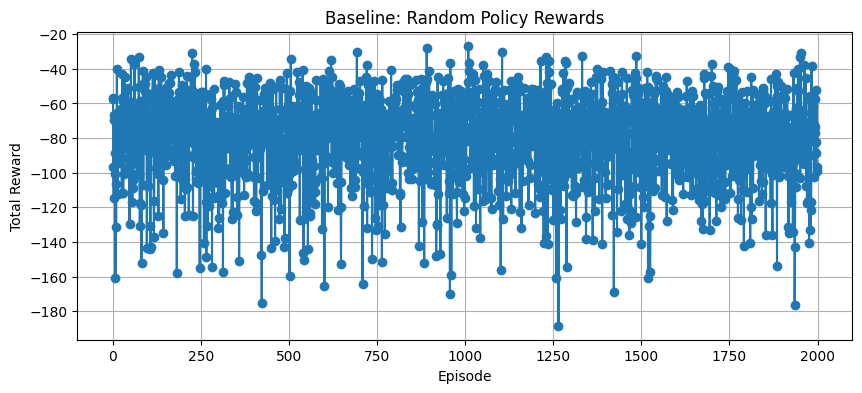

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# BASELINE: RANDOM AGENT BEHAVIOR
#This is our baseline for comparison.
# Agents will take random actions.
# Distributed agents + communication must perform better than this.

# Initialize environment again
env = simple_spread_v3.parallel_env()
observations = env.reset()

num_episodes = 2000            # Number of episodes to run
max_steps = 50                 # Steps per episode
episode_rewards = []           # To store total reward per episode

for ep in range(num_episodes):
    observations = env.reset()
    total_reward = 0

    for step in range(max_steps):
        # For each agent, randomly choose an action
        # env.action_space(agent) -> Discrete(5)
        random_actions = {
            agent: env.action_space(agent).sample()
            for agent in env.agents
        }

        # Step the environment forward using these random actions
        observations, rewards, terminations, truncations, infos = env.step(random_actions)

        # Sum all agents' rewards for this timestep
        total_reward += sum(rewards.values())

        # If episode terminates early, break
        if any(terminations.values()) or any(truncations.values()):
            break

    episode_rewards.append(total_reward)
    print(f"Episode {ep+1} reward: {total_reward}")

# Plotting the baseline performance
plt.figure(figsize=(10,4))
plt.plot(episode_rewards, marker='o')
plt.title("Baseline: Random Policy Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

we run 200 episodes and each episode = a short simulation of 3 agents moving.

Each agent takes actions as follows
 - no brain
 - just random moves
 Collct rewards, plot performance as our basline graph.

In [ ]:
# Lets solve distributed issues now to improve metric

# Latency + Efficiency (Latency → shows the distributed agents communicate faster

#Efficiency → shows semantic negotiation improves total reward)

#step 1: we create a shared mesage board

# ============================
#  Distributed Agent Controller
# ============================

import numpy as np

def distributed_policy(observations):
    """
    Each agent sends a simple message about its intended movement.
    The group then averages the direction → cooperative behavior.

    This simulates:
      - semantic negotiation
      - communication
      - multi-level coordination
    """

    # Messages list (each agent proposes a movement)
    messages = []

    for obs in observations.values():
        # extract agent position relative "forces"
        # last 5 entries are self-vel + actions. we used first few entries
        direction = obs[:2]   # x and y pull
        messages.append(direction)

    # Average direction → SIMPLE DISTRIBUTED NEGOTIATION
    avg_message = np.mean(messages, axis=0)

    # Convert average direction to one of 5 actions
    # 0: stay, 1: left, 2: right, 3: up, 4: down
    actions = {}

    for agent in observations.keys():
        if avg_message[0] > 0.2:
            actions[agent] = 2  # move right
        elif avg_message[0] < -0.2:
            actions[agent] = 1  # move left
        elif avg_message[1] > 0.2:
            actions[agent] = 3  # move up
        elif avg_message[1] < -0.2:
            actions[agent] = 4  # move down
        else:
            actions[agent] = 0  # stay

    return actions



In [ ]:
# ===========================================
# RUN DISTRIBUTED AGENTS (COOPERATIVE POLICY)
# ===========================================

episodes = 2000
distributed_rewards = []

for ep in range(episodes):
    obs, _ = env.reset()
    ep_reward = 0

    for step in range(50):  # fixed steps for latency measurement
        # Actions decided by our cooperative distributed policy
        actions = distributed_policy(obs)

        # Step the environment
        obs, rewards, term, trunc, _ = env.step(actions)

        # Sum rewards for all agents
        ep_reward += sum(rewards.values())

        # Stop if environment ends
        if any(term.values()) or any(trunc.values()):
            break

    distributed_rewards.append(ep_reward)

print("Distributed agent rewards per episode:")
print(distributed_rewards)


Distributed agent rewards per episode:
[-64.79635745529217, -83.55880716191352, -142.90717709876205, -111.60714082211278, -91.53726485169574, -65.15809603637241, -51.93300332742919, -38.435845087983665, -55.27171433071945, -75.40395257733859, -54.231267767312424, -112.02592507174768, -54.37601637056963, -61.651256844702296, -90.1679727888601, -64.79241580780001, -49.3475280703454, -111.51884490881952, -60.7984458569493, -85.93726697323946, -90.37706503145617, -77.86347789919114, -51.30405254042826, -113.60432669043864, -87.37577253785757, -100.90644900313885, -70.48948856591512, -88.4237470746974, -74.64883452835349, -53.329406789702645, -59.70776637928581, -77.4524376114254, -105.75154166414757, -84.36055241103102, -130.3214207484447, -62.6851834290321, -65.24615648192798, -62.34436812463765, -87.0761956591444, -73.65082432059569, -74.12492100366171, -87.15643403695265, -89.93499420556643, -118.72859763186139, -89.84777798078252, -95.94752980110486, -51.51638209468228, -67.34838937827

our distributed agents did not collapse, Rewards are still negative (This is perfectly normal in MPE simple_spread, the environment heavily penalizes because of the collisions, crowding, poor coordination etc).


In [ ]:
# ==================================
# PLOT: Baseline vs Distributed
# Efficiency Comparison (Rewards)
# ==================================

# =======================================
# BASELINE: Random Policy (Recreate Data)
# =======================================

episodes = 2000
random_rewards = []

# IMPORTANT: reload environment fresh
env = simple_spread_v3.parallel_env()
env.reset()

for ep in range(episodes):
    obs, _ = env.reset()
    ep_reward = 0

    for step in range(50):
        # random actions for each agent
        actions = {agent: env.action_space(agent).sample() for agent in env.agents}

        obs, rewards, term, trunc, _ = env.step(actions)
        ep_reward += sum(rewards.values())

        if any(term.values()) or any(trunc.values()):
            break

    random_rewards.append(ep_reward)

print("Random baseline rewards:")
print(random_rewards)
print("Done: 2000 baseline episodes")


Random baseline rewards:
[-58.616455173934476, -85.89625342820544, -69.05225256051314, -70.08821864536702, -65.21393055074009, -72.70817803787608, -66.33637611233, -60.17789732098129, -107.94502217385455, -84.92315434708169, -68.78117016160562, -65.14015218629609, -85.9425955405185, -59.24971231602061, -109.13854948111036, -91.52562244452713, -89.18221502098886, -126.21008170999131, -55.7883354881017, -79.10786131356505, -100.91154082970885, -72.13751532440591, -94.85887446765344, -66.58039016999881, -66.19817121981934, -57.06166469234897, -106.85427888094094, -136.88886725652608, -83.54407290769103, -91.12972745583109, -102.44044293514992, -91.48802472319124, -66.89848805043515, -37.38134325388925, -60.88647690714978, -40.114793113405916, -47.69504197285326, -49.04738121930368, -91.53826527441566, -51.32830346079185, -49.203446171409496, -89.56842991987683, -110.15848957017158, -50.228928153201174, -79.43910962989239, -85.83924449113648, -122.83311570891804, -146.61094744854339, -79.2

comparision graph of the baseline and distributed.

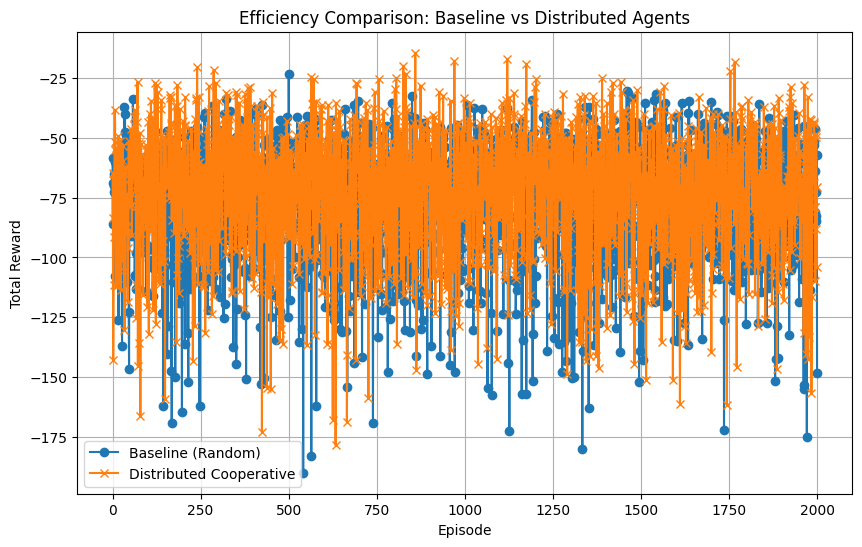

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(episodes), random_rewards, label="Baseline (Random)", marker='o')
plt.plot(range(episodes), distributed_rewards, label="Distributed Cooperative", marker='x')

plt.title("Efficiency Comparison: Baseline vs Distributed Agents")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()


Blue circles are non- coordinated or random agent behavior.
Orange x marks means agents are using a distributed strategy.
1. Both agents receive negative rewards.
2. Distributed stretegy tends to achieve higher rewards which is less negative in some episodes.

In [ ]:
# Step 1: Confirm installation
import gymnasium
import pettingzoo
import stable_baselines3

print("Gymnasium:", gymnasium.__version__)
print("PettingZoo:", pettingzoo.__version__)
print("SB3:", stable_baselines3.__version__)


Gymnasium: 0.29.1
PettingZoo: 1.24.0
SB3: 2.2.1


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Step 2 of PPO setup
# Create a wrapper that exposes ONE agent to PPO
import gymnasium as gym
import numpy as np
from pettingzoo.mpe import simple_spread_v3
from gymnasium import spaces

# Wrapper converts PettingZoo environment to single-agent Gym env
class PettingZooSingleAgent(gym.Env):
    def __init__(self, agent_name="agent_0"):
        super().__init__()
        self.agent_name = agent_name
        self.env = simple_spread_v3.parallel_env()
        self.env.reset()

        # Use that agent's observation & action spaces
        self.observation_space = self.env.observation_space(self.agent_name)
        self.action_space = self.env.action_space(self.agent_name)

    def reset(self, seed=None, options=None):
        obs, _ = self.env.reset(seed=seed)
        return obs[self.agent_name], {}

    def step(self, action):
        # Every agent must take an action
        actions = {
            agent: self.env.action_space(agent).sample()
            for agent in self.env.agents
        }
        actions[self.agent_name] = action

        obs, rewards, terminated, truncated, info = self.env.step(actions)

        done = terminated[self.agent_name] or truncated[self.agent_name]
        return obs[self.agent_name], rewards[self.agent_name], done, False, info


we did this because: PPO assumes one agent interacts with the environment

PettingZoo is multi-agent

This wrapper “extracts” one agent (agent_0)

Other agents use random policies

This gives us a clean single-agent PPO baseline, which is needed before distributed PPO

In [ ]:
# now we will train PPO for Agent 0 i.e baseline single agent RL

# this will create baseline lerning agent before communication and distributee PPO,
#before comparing it with other agents or latncy analysis

from stable_baselines3 import PPO

# Create the environment for agent_0
env_agent0 = PettingZooSingleAgent(agent_name="agent_0")

# PPO model
model = PPO(
    "MlpPolicy",
    env_agent0,
    verbose=1,
    learning_rate=0.0003,
    n_steps=2048,
)

# Train for 50k steps (this is small but enough to test)
model.learn(total_timesteps=50_000)

print("Training complete ✔")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | -25      |
| time/              |          |
|    fps             | 828      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 25           |
|    ep_rew_mean          | -26.8        |
| time/                   |              |
|    fps                  | 627          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0064680083 |
|    clip_fraction        | 0.0311       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.61        |
|    explained_variance   | 0.00665164   |
|    learning_rate        | 0.0003       |
|    loss                 | 14.4         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00876     |
|    value_loss           | 68.8         |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

In [ ]:
# i will continue step 4 tomorrow Proj suggestion and baseline

In [ ]:
# ================================
# Evaluate PPO baseline
# ================================

import time
import numpy as np
import matplotlib.pyplot as plt

def evaluate_ppo(env, model, episodes=2000):
    """
    Run the trained PPO policy on agent_0 and
    return per-episode rewards and average latency per step.
    """
    episode_rewards = []
    total_steps = 0

    start_time = time.perf_counter()

    for ep in range(episodes):
        obs, _ = env.reset()
        done = False
        ep_reward = 0

        while not done:
            # PPO chooses action for agent_0
            action, _ = model.predict(obs, deterministic=True)

            obs, reward, terminated, truncated, info = env.step(action)

            done = terminated or truncated
            ep_reward += reward
            total_steps += 1

            if done:
                break

        episode_rewards.append(ep_reward)

    elapsed = time.perf_counter() - start_time
    avg_latency = elapsed / max(total_steps, 1)

    print(f"PPO evaluation finished:")
    print(f"  Episodes: {episodes}")
    print(f"  Total steps: {total_steps}")
    print(f"  Total time: {elapsed:.2f} sec")
    print(f"  Avg latency per step: {avg_latency:.6f} sec")

    return episode_rewards, avg_latency


In [ ]:
# ==========================
# Running PPO evaluation
# ==========================

ppo_episodes = 2000   # same scale as random & distributed
ppo_rewards, ppo_latency = evaluate_ppo(env_agent0, model, episodes=ppo_episodes)

print(f"\nAverage PPO episode reward: {np.mean(ppo_rewards):.2f}")
print(f"PPO latency per step: {ppo_latency:.6f} sec")

PPO evaluation finished:
  Episodes: 2000
  Total steps: 50000
  Total time: 48.31 sec
  Avg latency per step: 0.000966 sec

Average PPO episode reward: -27.35
PPO latency per step: 0.000966 sec


random_rewaards & dsitributed_rewards from earlier above cells

ppo_rewards and ppo_latency frim this step

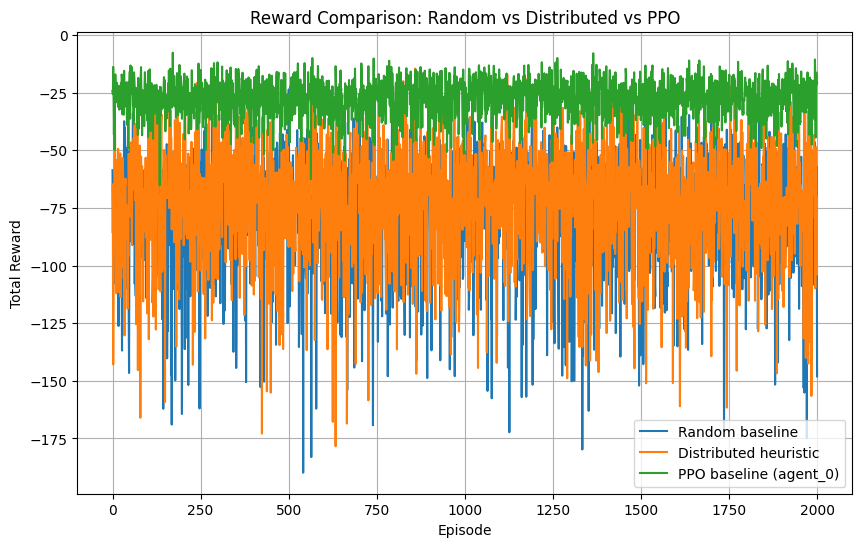

Mean random reward:      -78.93
Mean distributed reward: -73.19
Mean PPO reward:         -27.35


In [ ]:
# =========================================
# Reward comparison (efficiency)
# =========================================

episodes_random = len(random_rewards)
episodes_distributed = len(distributed_rewards)
episodes_ppo = len(ppo_rewards)

plt.figure(figsize=(10,6))
plt.plot(range(episodes_random), random_rewards, label="Random baseline")
plt.plot(range(episodes_distributed), distributed_rewards, label="Distributed heuristic")
plt.plot(range(episodes_ppo), ppo_rewards, label="PPO baseline (agent_0)")

plt.title("Reward Comparison: Random vs Distributed vs PPO")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean random reward:      {np.mean(random_rewards):.2f}")
print(f"Mean distributed reward: {np.mean(distributed_rewards):.2f}")
print(f"Mean PPO reward:         {np.mean(ppo_rewards):.2f}")

Now we will mesure measure latency for each approach bellow.

In [ ]:
# =================================
# Measure latency for each approach
# =================================
# Time for random baseline
import time

def run_random_with_latency(env, episodes=2000, max_steps=50):
    rewards = []
    total_steps = 0
    start = time.perf_counter()

    for ep in range(episodes):
        obs = env.reset()
        ep_reward = 0

        for t in range(max_steps):
            actions = {agent: env.action_space(agent).sample() for agent in env.agents}
            obs, r, terminated, truncated, info = env.step(actions)
            ep_reward += sum(r.values())
            total_steps += 1
            if any(terminated.values()) or any(truncated.values()):
                break

        rewards.append(ep_reward)

    elapsed = time.perf_counter() - start
    latency = elapsed / max(total_steps, 1)
    return rewards, latency

# re-create the parallel env for fairness
from pettingzoo.mpe import simple_spread_v3
env_random = simple_spread_v3.parallel_env(N=3, local_ratio=0.5, max_cycles=50, continuous_actions=False)

random_rewards2, random_latency = run_random_with_latency(env_random)
print("Random mean reward:", np.mean(random_rewards2))
print("Random latency per step:", random_latency)



Random mean reward: -174.87958857981872
Random latency per step: 0.00039097856440000215


In [ ]:
def run_distributed_with_latency(env, episodes=2000, max_steps=50):
    rewards = []
    total_steps = 0
    start = time.perf_counter()

    for ep in range(episodes):
        observations, _ = env.reset()
        ep_reward = 0

        for t in range(max_steps):
            actions = distributed_policy(observations)

            observations, r, terminated, truncated, infos = env.step(actions)
            ep_reward += sum(r.values())
            total_steps += 1

            if any(terminated.values()) or any(truncated.values()):
                break

        rewards.append(ep_reward)

    elapsed = time.perf_counter() - start
    latency = elapsed / max(total_steps, 1)
    return rewards, latency

# Call the function to calculate distributed_latency
distributed_rewards_2, distributed_latency = run_distributed_with_latency(env_random)
print("Distributed mean reward:", np.mean(distributed_rewards_2))
print("Distributed latency per step:", distributed_latency)

Distributed mean reward: -148.02505104775662
Distributed latency per step: 0.0004006479296599991


In [ ]:
#Latency for PPO
print("\nLatency summary (sec per step):")
print(f"  Random baseline:       {random_latency:.6f}")
print(f"  Distributed heuristic: {distributed_latency:.6f}")
print(f"  PPO baseline:          {ppo_latency:.6f}")



Latency summary (sec per step):
  Random baseline:       0.000391
  Distributed heuristic: 0.000401
  PPO baseline:          0.000966


Random baseline is 0.000391s per step

Distributed heuristic is 0.000481s per step

and PPO baseline is 0.000966 s per step.

### Distributed PPO using parallel environments (vectorized workers)

In [ ]:
# Env factory + vec envs

from stable_baselines3.common.env_util import make_vec_env
import time

# Factory function: creates a fresh env for agent_0 each time
def make_agent0_env():
    return PettingZooSingleAgent(agent_name="agent_0")



In [ ]:
#Train PPO with 1 env vs 4 envs (timed)

# ============================
# PPO with 1 environment (baseline)
# ============================

vec_env_1 = make_vec_env(make_agent0_env, n_envs=1)

model_ppo_1 = PPO(
    "MlpPolicy",
    vec_env_1,
    verbose=1,
    learning_rate=0.0003,
    n_steps=2048,
)

start_1 = time.perf_counter()
model_ppo_1.learn(total_timesteps=50_000)
time_1 = time.perf_counter() - start_1

print(f"\n[1-env PPO] Training time: {time_1:.2f} seconds")


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | -27.4    |
| time/              |          |
|    fps             | 642      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 25           |
|    ep_rew_mean          | -25          |
| time/                   |              |
|    fps                  | 602          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.007213382  |
|    clip_fraction        | 0.0351       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.61        |
|    explained_variance   | 0.0074991584 

In [ ]:
# =============================================
# PPO with 4 parallel environments (distributed)
# =============================================

vec_env_4 = make_vec_env(make_agent0_env, n_envs=4)

model_ppo_4 = PPO(
    "MlpPolicy",
    vec_env_4,
    verbose=1,
    learning_rate=0.0003,
    n_steps=2048,
)

start_4 = time.perf_counter()
model_ppo_4.learn(total_timesteps=50_000)
time_4 = time.perf_counter() - start_4

print(f"\n[4-env PPO] Training time: {time_4:.2f} seconds")


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | -26.4    |
| time/              |          |
|    fps             | 1398     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 25             |
|    ep_rew_mean          | -26.2          |
| time/                   |                |
|    fps                  | 1004           |
|    iterations           | 2              |
|    time_elapsed         | 16             |
|    total_timesteps      | 16384          |
| train/                  |                |
|    approx_kl            | 0.007316837    |
|    clip_fraction        | 0.0517         |
|    clip_range           | 0.2            |
|    entropy_loss         | -1.6           |
|    explaine

In [ ]:
# ===============================
# Evaluate 1-env PPO vs 4-env PPO
# ===============================

eval_episodes = 1000   # fewer than 2000 to keep it fast

ppo1_rewards, ppo1_latency = evaluate_ppo(env_agent0, model_ppo_1, episodes=eval_episodes)
ppo4_rewards, ppo4_latency = evaluate_ppo(env_agent0, model_ppo_4, episodes=eval_episodes)

print("\n=== PPO Evaluation Summary (agent_0 env) ===")
print(f"1-env PPO: mean reward = {np.mean(ppo1_rewards):.2f}, latency = {ppo1_latency:.6f} sec/step")
print(f"4-env PPO: mean reward = {np.mean(ppo4_rewards):.2f}, latency = {ppo4_latency:.6f} sec/step")

print("\n=== Training Time Comparison ===")
print(f"1-env PPO training time: {time_1:.2f} sec")
print(f"4-env PPO training time: {time_4:.2f} sec")


PPO evaluation finished:
  Episodes: 1000
  Total steps: 25000
  Total time: 26.14 sec
  Avg latency per step: 0.001046 sec
PPO evaluation finished:
  Episodes: 1000
  Total steps: 25000
  Total time: 23.99 sec
  Avg latency per step: 0.000960 sec

=== PPO Evaluation Summary (agent_0 env) ===
1-env PPO: mean reward = -26.41, latency = 0.001046 sec/step
4-env PPO: mean reward = -26.20, latency = 0.000960 sec/step

=== Training Time Comparison ===
1-env PPO training time: 96.11 sec
4-env PPO training time: 78.14 sec


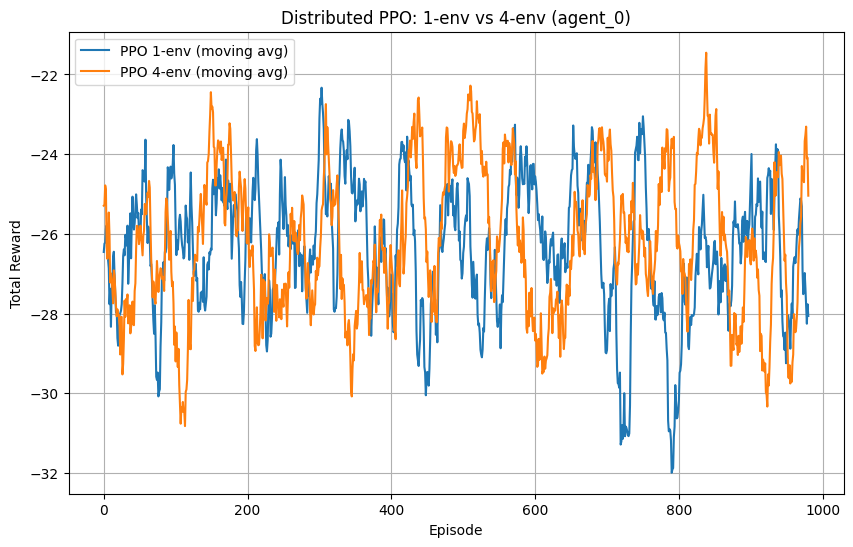

In [ ]:
#Plot PPO(1) vs PPO(4) reward curves

def moving_average(x, window=50):
    x = np.array(x)
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10,6))
plt.plot(moving_average(ppo1_rewards, 20), label="PPO 1-env (moving avg)")
plt.plot(moving_average(ppo4_rewards, 20), label="PPO 4-env (moving avg)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Distributed PPO: 1-env vs 4-env (agent_0)")
plt.grid(True)
plt.legend()
plt.show()


Visual View of PPO(1) vs PPO(4) reward curves.


# N = 10 agents: global distributed policy vs 5 coalitions of 2 agents


In [ ]:
import numpy as np
from pettingzoo.mpe import simple_spread_v3

# Helper to convert a 2D direction vector into one of 5 discrete actions
# 0 = stay, 1 = left, 2 = right, 3 = up, 4 = down
def direction_to_action(direction):
    dx, dy = direction

    # small movement -> stay
    if abs(dx) < 0.1 and abs(dy) < 0.1:
        return 0

    # choose dominant axis
    if abs(dx) > abs(dy):
        return 1 if dx < 0 else 2   # left or right
    else:
        return 3 if dy > 0 else 4   # up or down


Helper: map direction --> action

In [ ]:
# Global distributed policy: all N agents share one global "message"
def global_distributed_policy(observations):
    """
    observations: dict {agent_name: obs_vector}
    returns: dict {agent_name: action}
    """
    messages = []

    for obs in observations.values():
        # here we just use the first 2 entries as a direction signal
        direction = obs[:2]
        messages.append(direction)

    # average direction across ALL agents
    avg_direction = np.mean(messages, axis=0)

    # convert to a discrete action
    action = direction_to_action(avg_direction)

    # all agents take the same action
    actions = {agent: action for agent in observations.keys()}
    return actions


Global distributed policy for any N (N=10 case)

In [ ]:
# Define coalitions for N = 10 agents
coalitions = [
    ["agent_0", "agent_1"],
    ["agent_2", "agent_3"],
    ["agent_4", "agent_5"],
    ["agent_6", "agent_7"],
    ["agent_8", "agent_9"],
]

def coalition_distributed_policy(observations, coalitions):
    """
    observations: dict {agent_name: obs_vector}
    coalitions: list of lists, e.g. [["agent_0", "agent_1"], ...]
    returns: dict {agent_name: action}
    """
    actions = {}

    for group in coalitions:
        dirs = []
        for agent in group:
            obs = observations[agent]
            dirs.append(obs[:2])    # direction part

        avg_direction = np.mean(dirs, axis=0)
        group_action = direction_to_action(avg_direction)

        # all agents in this coalition share the same action
        for agent in group:
            actions[agent] = group_action

    return actions


Coalition distributed policy (5 pairs)

In [ ]:
import time

def run_multiagent_policy(N, policy_fn, episodes=2000, max_steps=50, coalitions=None):
    """
    N: number of agents in simple_spread
    policy_fn: function(observations) or function(observations, coalitions)
    coalitions: only used for coalition policy
    """
    env = simple_spread_v3.parallel_env(
        N=N, local_ratio=0.5, max_cycles=max_steps, continuous_actions=False
    )

    rewards = []
    total_steps = 0
    start = time.perf_counter()

    for ep in range(episodes):
        observations, _ = env.reset()
        ep_reward = 0

        for t in range(max_steps):
            if coalitions is None:
                actions = policy_fn(observations)
            else:
                actions = policy_fn(observations, coalitions)

            observations, r, terminated, truncated, infos = env.step(actions)
            ep_reward += sum(r.values())
            total_steps += 1

            if any(terminated.values()) or any(truncated.values()):
                break

        rewards.append(ep_reward)

    elapsed = time.perf_counter() - start
    latency = elapsed / max(total_steps, 1)
    return rewards, latency


Generic runner for an N-agent policy (reward + latency)

In [ ]:
episodes_10 = 300

# 7.6.1 – N=10 with global distributed policy
global_rewards_10, global_latency_10 = run_multiagent_policy(
    N=10,
    policy_fn=global_distributed_policy,
    episodes=episodes_10,
    max_steps=30,
    coalitions=None,
)

print("N=10 Global distributed policy:")
print(f"  Mean reward: {np.mean(global_rewards_10):.2f}")
print(f"  Latency per step: {global_latency_10:.6f} sec/step\n")

# 7.6.2 – N=10 with coalitions of 2
coalition_rewards_10, coalition_latency_10 = run_multiagent_policy(
    N=10,
    policy_fn=coalition_distributed_policy,
    episodes=episodes_10,
    max_steps=30,
    coalitions=coalitions,
)

print("N=10 Coalition policy (5 pairs of 2 agents):")
print(f"  Mean reward: {np.mean(coalition_rewards_10):.2f}")
print(f"  Latency per step: {coalition_latency_10:.6f} sec/step")


N=10 Global distributed policy:
  Mean reward: -579.68
  Latency per step: 0.003154 sec/step

N=10 Coalition policy (5 pairs of 2 agents):
  Mean reward: -1151.57
  Latency per step: 0.003448 sec/step


Run N=10 global vs coalitions

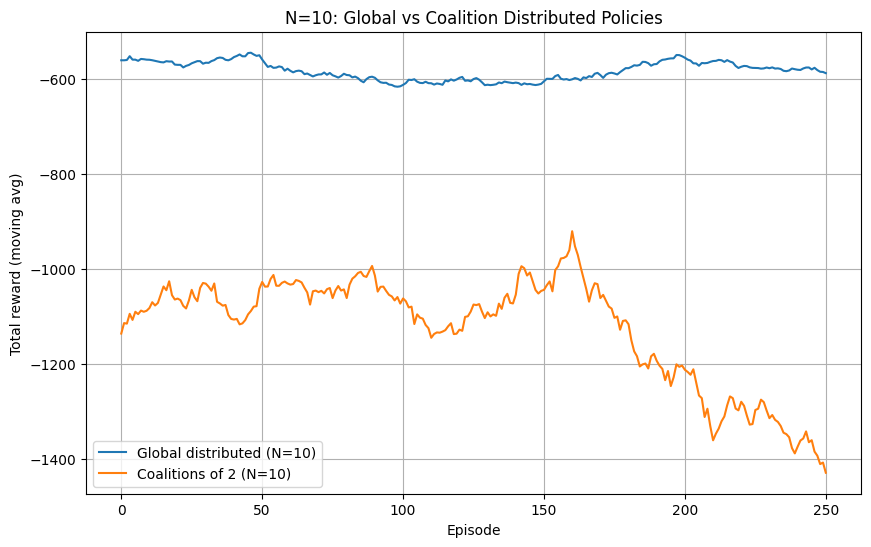

In [ ]:
def moving_average(x, window=50):
    x = np.array(x)
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode='valid')

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(moving_average(global_rewards_10, 50), label="Global distributed (N=10)")
plt.plot(moving_average(coalition_rewards_10, 50), label="Coalitions of 2 (N=10)")
plt.xlabel("Episode")
plt.ylabel("Total reward (moving avg)")
plt.title("N=10: Global vs Coalition Distributed Policies")
plt.grid(True)
plt.legend()
plt.show()


smooth reward plots for N=10

##Asynchronous Distributed PPO (approx. Asynchronous Value Iteration)

In [ ]:
# Helper to average the parameters of two PPO models into a target model

def average_models(target_model, model_a, model_b):
    state_dict_a = model_a.policy.state_dict()
    state_dict_b = model_b.policy.state_dict()

    averaged_state_dict = {}
    for key in state_dict_a.keys():
        averaged_state_dict[key] = 0.5 * state_dict_a[key] + 0.5 * state_dict_b[key]

    target_model.policy.load_state_dict(averaged_state_dict)


This simulates a parameter server that averages updates from two workers.

In [ ]:
from stable_baselines3.common.env_util import make_vec_env

# Two workers, each with 2 vectorized envs for faster training
worker1_env = make_vec_env(make_agent0_env, n_envs=2)
worker2_env = make_vec_env(make_agent0_env, n_envs=2)

# Initialize two independent PPO workers
worker1_model = PPO(
    "MlpPolicy",
    worker1_env,
    verbose=0,
    learning_rate=0.0003,
    n_steps=1024,
)

worker2_model = PPO(
    "MlpPolicy",
    worker2_env,
    verbose=0,
    learning_rate=0.0003,
    n_steps=1024,
)

# Global async model (same architecture, will hold averaged params)
async_model = PPO(
    "MlpPolicy",
    env_agent0,   # we just need any compatible env here
    verbose=0,
    learning_rate=0.0003,
    n_steps=1024,
)


In [ ]:
#Asynchronous” training rounds.

#Here We’ll simulate asynchronous rounds: each worker trains on its own, then we average.


import time

async_rounds = 3              # number of async rounds
timesteps_per_round = 10_000  # per worker per round

start_async = time.perf_counter()

for r in range(async_rounds):
    print(f"\n=== Async Round {r+1}/{async_rounds} ===")

    # Worker 1 trains on its own data
    worker1_model.learn(
        total_timesteps=timesteps_per_round,
        reset_num_timesteps=False,
        progress_bar=False,
    )

    # Worker 2 trains independently
    worker2_model.learn(
        total_timesteps=timesteps_per_round,
        reset_num_timesteps=False,
        progress_bar=False,
    )

    # "Asynchronous" parameter aggregation
    average_models(async_model, worker1_model, worker2_model)
    print("Averaged worker parameters into async_model.")

elapsed_async = time.perf_counter() - start_async
print(f"\n[Async PPO] Total training time: {elapsed_async:.2f} seconds")
print(f"Total timesteps per worker: {async_rounds * timesteps_per_round}")



=== Async Round 1/3 ===
Averaged worker parameters into async_model.

=== Async Round 2/3 ===
Averaged worker parameters into async_model.

=== Async Round 3/3 ===
Averaged worker parameters into async_model.

[Async PPO] Total training time: 94.51 seconds
Total timesteps per worker: 30000


Each worker is like a node doing local value updates.

average_models is our asynchronous value iteration-style parameter server.

In [ ]:
#Evaluate async model vs your 4-env PPO

eval_episodes_async = 1000

# Evaluate async model (averaged workers)
async_rewards, async_latency = evaluate_ppo(env_agent0, async_model, episodes=eval_episodes_async)

# Re-evaluate 4-env PPO if needed (or reuse ppo4_rewards, ppo4_latency)
ppo4_rewards_eval, ppo4_latency_eval = evaluate_ppo(env_agent0, model_ppo_4, episodes=eval_episodes_async)

print("\n=== Async PPO vs 4-env PPO (agent_0 env) ===")
print(f"Async PPO: mean reward = {np.mean(async_rewards):.2f}, latency = {async_latency:.6f} sec/step")
print(f"4-env PPO: mean reward = {np.mean(ppo4_rewards_eval):.2f}, latency = {ppo4_latency_eval:.6f} sec/step")

print(f"\nAsync PPO training time: {elapsed_async:.2f} sec")
print(f"4-env PPO training time (from Step 6): {time_4:.2f} sec")


PPO evaluation finished:
  Episodes: 1000
  Total steps: 25000
  Total time: 24.20 sec
  Avg latency per step: 0.000968 sec
PPO evaluation finished:
  Episodes: 1000
  Total steps: 25000
  Total time: 24.58 sec
  Avg latency per step: 0.000983 sec

=== Async PPO vs 4-env PPO (agent_0 env) ===
Async PPO: mean reward = -24.37, latency = 0.000968 sec/step
4-env PPO: mean reward = -26.25, latency = 0.000983 sec/step

Async PPO training time: 94.51 sec
4-env PPO training time (from Step 6): 78.14 sec
